In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle

In [2]:
SR_pic_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
with open(SR_pic_file_path, 'rb') as file:
    SR_pic_data = pickle.load(file)

In [3]:
for key in SR_pic_data:
    rainfall_array_final = [] 
    for j in range(SR_pic_data[key].shape[0]):
        k = SR_pic_data[key][j][1:,:]
        k = k[:,3:-4]
        rainfall_array_final.append(k)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_pic_data[key] = rainfall_array_final

In [4]:
print(SR_pic_data[1901][0].shape)

(128, 128)


In [5]:
def calculate_daily_max(SR_data):
    daily_max = {year: [0] * SR_data[year].shape[0] for year in range(1901, 2024)}

    for year in range(1901, 2024):
        for i in range(SR_data[year].shape[0]):
            daily_max[year][i] = np.nanmax(SR_data[year][i])

    return daily_max

def normalize_with_daily_max(SR_data, daily_max):
    for year in range(1901, 2024):
        for i in range(SR_data[year].shape[0]):
            max_value = daily_max[year][i]
            if max_value != 0:
                SR_data[year][i] /= max_value
            SR_data[year][i][np.isnan(SR_data[year][i])] = 0
    return SR_data

def Dataprocessing(SR_data):
    daily_max = calculate_daily_max(SR_data)
    SR_data = normalize_with_daily_max(SR_data, daily_max)
    return daily_max

In [6]:
daily_max = Dataprocessing(SR_pic_data)

In [7]:
data = []
for year in SR_pic_data:
    for i in range(SR_pic_data[year].shape[0]):
        data.append(SR_pic_data[year][i])
data=np.array(data)

In [8]:
latent_dim = 256

# Encoder
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


x = layers.Flatten()(x)

# Latent space representation
x = layers.Dense(latent_dim*2)(x)
z = layers.Dense(latent_dim, name='latent_space')(x)
z = layers.Dense(latent_dim*2)(z)
# Decoder
x = layers.Dense(8 * 8 * 512, activation='relu')(z)
x = layers.Reshape((8, 8, 512))(x)

x = layers.Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)
autoencoder = models.Model(input_layer, decoded, name="autoencoder")
# def ssim_loss(y_true, y_pred):
#     return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
def combined_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.9 * ssim_loss + 0.1* mse_loss
autoencoder.compile(optimizer='adam', loss=combined_loss,metrics = ['mse'])
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32768)          │    16,809,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     2,359,80

 Total params: 45,549,121 (173.76 MB)

 Trainable params: 45,545,281 (173.74 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [9]:
autoencoder.fit(data,data,epochs=20,batch_size=32)

Epoch 1/20


I0000 00:00:1728670263.393935      75 service.cc:145] XLA service 0x7fc678001e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728670263.395348      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1728670264.355102      75 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728670264.356295      75 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728670264.357158      75 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728670264.357728      75 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert


   2/1404 ━━━━━━━━━━━━━━━━━━━━ 1:59 85ms/step - loss: 0.9303 - mse: 0.3103  

I0000 00:00:1728670277.390425      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1403/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2329 - mse: 0.0470

W0000 00:00:1728670388.817703      73 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1728670388.818057      73 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1728670388.818522      73 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1728670388.818813      73 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 145s 87ms/step - loss: 0.2328 - mse: 0.0470
Epoch 2/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1220 - mse: 0.0012
Epoch 3/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1134 - mse: 0.0010
Epoch 4/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1096 - mse: 9.9241e-04
Epoch 5/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1044 - mse: 9.4573e-04
Epoch 6/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1025 - mse: 9.1015e-04
Epoch 7/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.1007 - mse: 8.9251e-04
Epoch 8/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 110s 79ms/step - loss: 0.1003 - mse: 8.8308e-04
Epoch 9/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 110s 79ms/step - loss: 0.0993 - mse: 8.7330e-04
Epoch 10/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.0983 - mse: 8.6018e-04
Epoch 11/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.0979 - mse: 8.5394e-04
Epoch 12/20
1404/1404 ━━━━━━━━━

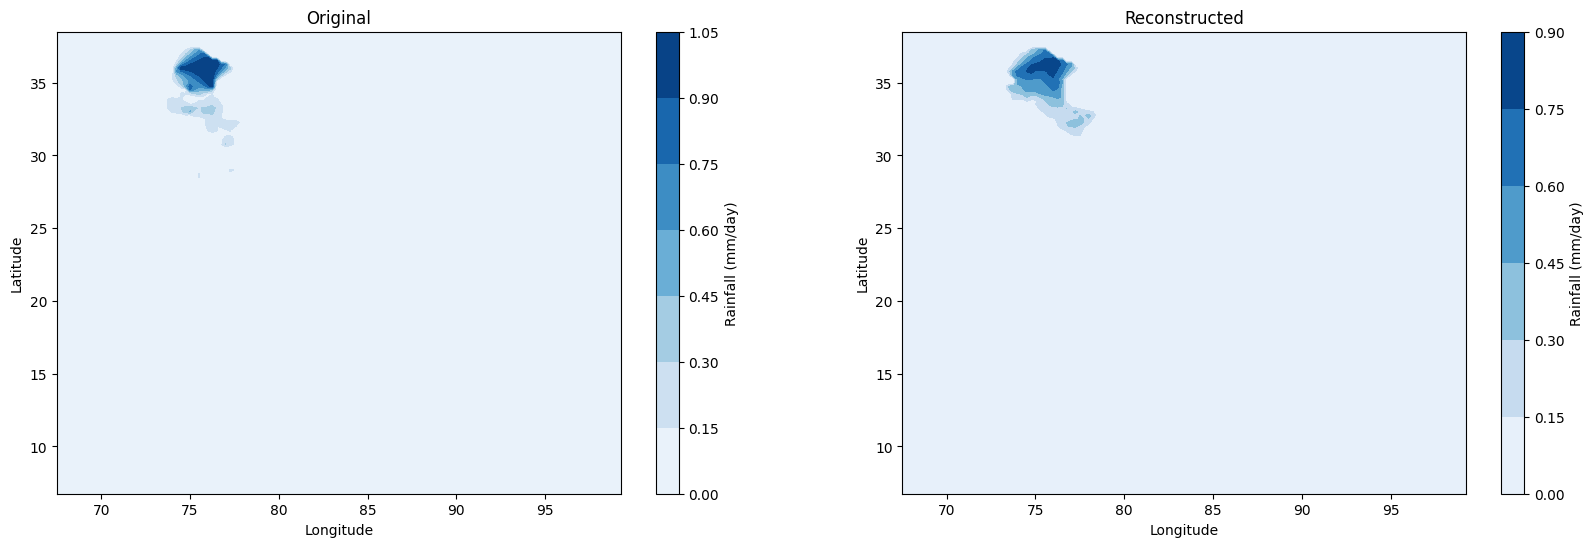

In [10]:
predict = autoencoder(SR_pic_data[1950][0].reshape((1,128,128,1)))
predict = np.array(predict)
lon = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')
lat = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon = lon[4:-4]
X_SR, Y_SR = np.meshgrid(lon, lat)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
im1 = axes[0].contourf(X_SR, Y_SR,SR_pic_data[1950][0], cmap='Blues')
axes[0].set_title('Original')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(im1, ax=axes[0], label='Rainfall (mm/day)')
im2 = axes[1].contourf(X_SR, Y_SR, predict.reshape(128,128), cmap='Blues')
axes[1].set_title('Reconstructed')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(im2, ax=axes[1], label='Rainfall (mm/day)')
plt.show()

In [11]:
autoencoder.save('autoencoder_fe.keras')